## Reference implementation (GD / SGD / Averaged SGD + plots)

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

FIG_DIR = "../Figures/hw1"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- objective, gradients ----------
def loss_ridge(X, y, w, lam):
    n = X.shape[0]
    r = X @ w - y
    return 0.5 / n * (r @ r) + 0.5 * lam * (w @ w)

def grad_full(X, y, w, lam):
    n = X.shape[0]
    return (X.T @ (X @ w - y)) / n + lam * w

def grad_minibatch(X, y, w, lam, idx):
    Xb = X[idx]
    yb = y[idx]
    b = Xb.shape[0]
    return (Xb.T @ (Xb @ w - yb)) / b + lam * w

def smoothness_L(X, lam):
    """
    L = ||X||_op^2 / n + lam
    np.linalg.norm(X, 2) returns the spectral norm (largest singular value).
    """
    n = X.shape[0]
    smax = np.linalg.norm(X, 2)
    return (smax ** 2) / n + lam

# ---------- Batch GD ----------
def run_gd(Xtr, ytr, Xva, yva, lam, eta, num_iters, w0=None):
    d = Xtr.shape[1]
    n = Xtr.shape[0]
    w = np.zeros(d) if w0 is None else w0.copy()

    iters = []
    tr = []
    va = []
    grad_evals = []

    for k in range(num_iters + 1):
        iters.append(k)
        grad_evals.append(k * n)
        tr.append(loss_ridge(Xtr, ytr, w, lam))
        va.append(loss_ridge(Xva, yva, w, lam))
        if k == num_iters:
            break
        w = w - eta * grad_full(Xtr, ytr, w, lam)

    return np.array(iters), np.array(grad_evals), np.array(tr), np.array(va), w

# ---------- SGD (optionally with Polyak-Ruppert averaging) ----------
def run_sgd(Xtr, ytr, Xva, yva, lam, eta, b, grad_eval_budget, w0=None, seed=42, averaging=False):
    """
    Runs SGD until using approximately grad_eval_budget sample-grad evaluations.
    Counts 'gradient evaluations' as #samples used in mini-batches.
    """
    rng = np.random.default_rng(seed)
    d = Xtr.shape[1]
    n = Xtr.shape[0]
    w = np.zeros(d) if w0 is None else w0.copy()

    # running average
    wbar = np.zeros_like(w)
    t = 0  # number of SGD updates performed

    evals = []
    tr = []
    va = []

    used = 0
    while True:
        # record current curve value
        w_plot = (wbar if averaging else w) if t > 0 else w
        evals.append(used)
        tr.append(loss_ridge(Xtr, ytr, w_plot, lam))
        va.append(loss_ridge(Xva, yva, w_plot, lam))

        if used >= grad_eval_budget:
            break

        # sample a mini-batch uniformly
        idx = rng.choice(n, size=b, replace=(b > n))  # b<=n typically, so replace=False
        g = grad_minibatch(Xtr, ytr, w, lam, idx)
        w = w - eta * g

        t += 1
        if averaging:
            # wbar = (1/t) sum_{k=1}^t w_k
            wbar = wbar + (w - wbar) / t

        used += b

    return np.array(evals), np.array(tr), np.array(va), w, wbar

# ---------- SGD by epochs (for Part III: loss vs epochs) ----------
def run_sgd_epochs(Xtr, ytr, Xva, yva, lam, eta, b, num_epochs, w0=None, seed=42):
    """Run SGD for num_epochs; one epoch = one pass over data (ceil(n/b) updates).
    Returns (epoch_indices, tr_loss_per_epoch, va_loss_per_epoch, w_final)."""
    rng = np.random.default_rng(seed)
    n, d = Xtr.shape[0], Xtr.shape[1]
    w = np.zeros(d) if w0 is None else w0.copy()
    steps_per_epoch = max(1, (n + b - 1) // b)
    tr_list = [loss_ridge(Xtr, ytr, w, lam)]
    va_list = [loss_ridge(Xva, yva, w, lam)]
    for epoch in range(num_epochs):
        for _ in range(steps_per_epoch):
            idx = rng.choice(n, size=b, replace=(b > n))
            g = grad_minibatch(Xtr, ytr, w, lam, idx)
            w = w - eta * g
        tr_list.append(loss_ridge(Xtr, ytr, w, lam))
        va_list.append(loss_ridge(Xva, yva, w, lam))
    return np.arange(num_epochs + 1), np.array(tr_list), np.array(va_list), w

# ---------- Plot helpers ----------
def plot_curves(x, curves_dict, title, xlabel):
    plt.figure()
    for label, y in curves_dict.items():
        plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    os.makedirs(FIG_DIR, exist_ok=True)
    fname = "".join(c if c.isalnum() or c in "_-" else "_" for c in title).strip("_") or "figure"
    plt.savefig(os.path.join(FIG_DIR, f"{fname}.png"), bbox_inches="tight")
    plt.show()


In [9]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Dataset preparation: 75% train, 25% test (used as validation in plots)
X, y = load_diabetes(return_X_y=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42)
lam = 1e-3

## Part I(b) experiment driver (GD with $\eta \in\{0.1 / L, 0.5 / L, 1 / L, 1.5 / L\}$ )

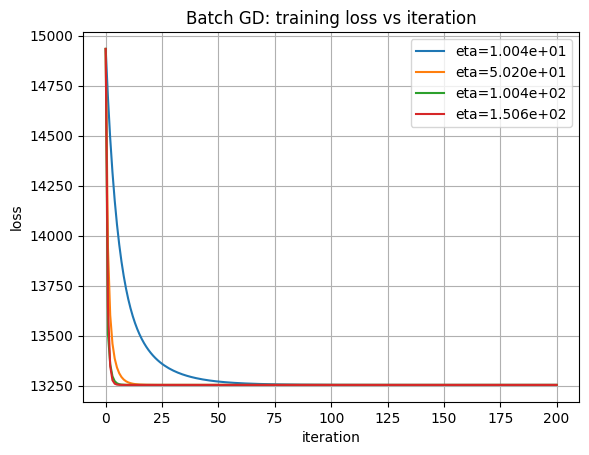

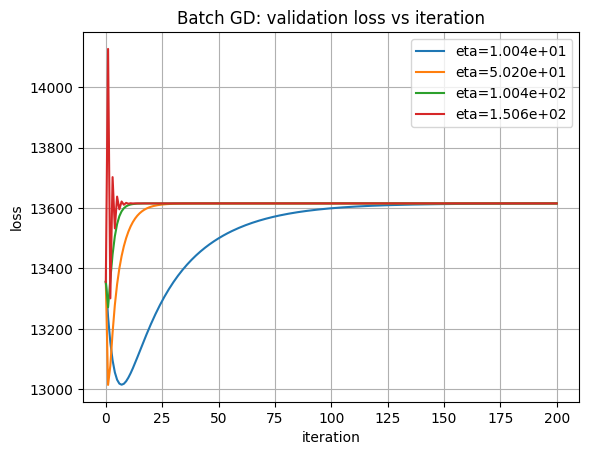

In [10]:
# compute L on training data (common choice)
L = smoothness_L(X_train, lam)
etas = [0.1/L, 0.5/L, 1.0/L, 1.5/L]

num_iters = 200  # "epochs" for batch GD

train_curves = {}
val_curves = {}

for eta in etas:
    iters, grad_evals, tr, va, wT = run_gd(X_train, y_train, X_val, y_val, lam, eta, num_iters)
    train_curves[f"eta={eta:.3e}"] = tr
    val_curves[f"eta={eta:.3e}"] = va

plot_curves(iters, train_curves, "Batch GD: training loss vs iteration", "iteration")
plot_curves(iters, val_curves, "Batch GD: validation loss vs iteration", "iteration")


## Part II(a) experiment driver (SGD batch sizes, plot vs gradient evaluations)

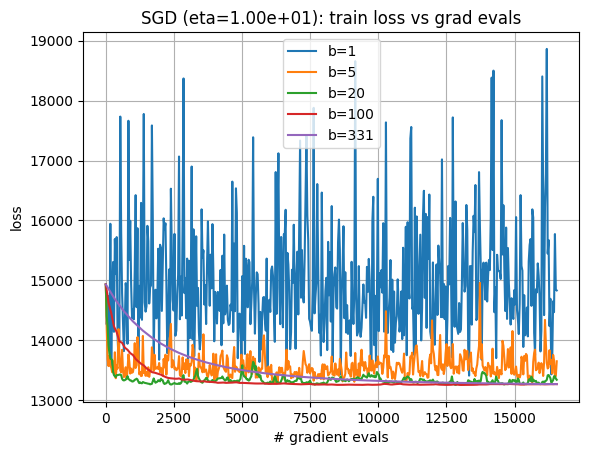

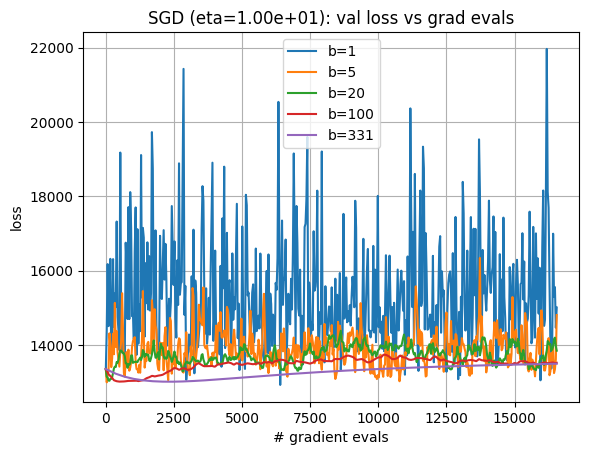

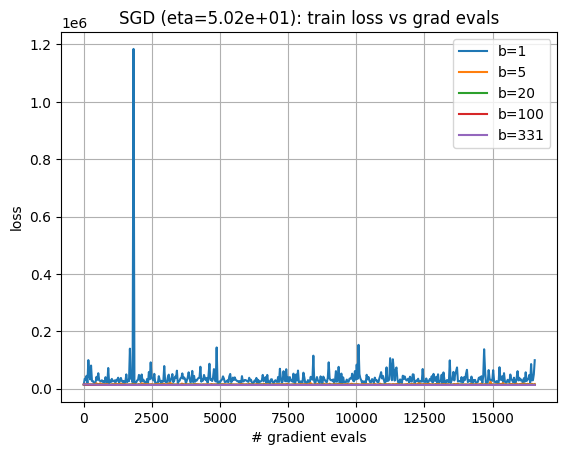

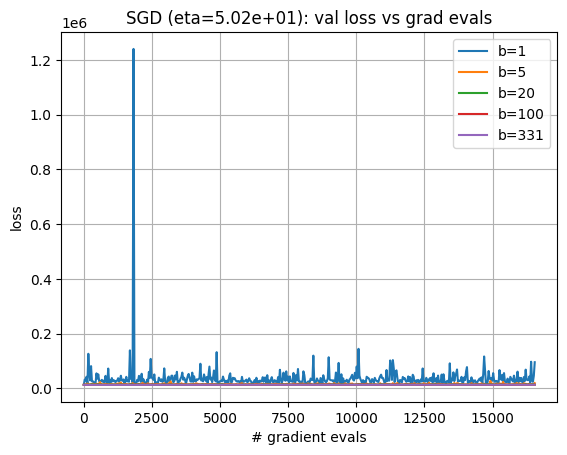

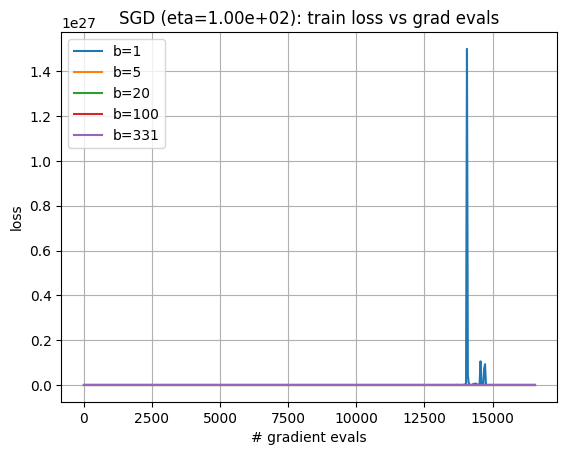

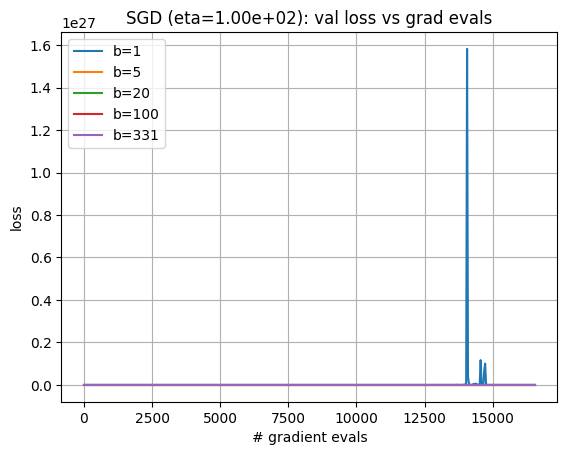

In [11]:
L = smoothness_L(X_train, lam)

# pick a few SGD stepsizes to test (often smaller than GD works better)
sgd_etas = [0.1/L, 0.5/L, 1.0/L]

batch_sizes = [1, 5, 20, 100, X_train.shape[0]]  # includes full batch

budget = 50 * X_train.shape[0]  # e.g., 50 epochs worth of sample grads

# common x-axis so curves from different batch sizes (different lengths) can be overlaid
common_x = np.linspace(0, budget, 500)

for eta in sgd_etas:
    train_curves = {}
    val_curves = {}

    for b in batch_sizes:
        evals, tr, va, wT, wbar = run_sgd(
            X_train, y_train, X_val, y_val,
            lam=lam, eta=eta, b=b,
            grad_eval_budget=budget,
            averaging=False
        )
        train_curves[f"b={b}"] = np.interp(common_x, evals, tr)
        val_curves[f"b={b}"] = np.interp(common_x, evals, va)

    plot_curves(common_x, train_curves, f"SGD (eta={eta:.2e}): train loss vs grad evals", "# gradient evals")
    plot_curves(common_x, val_curves, f"SGD (eta={eta:.2e}): val loss vs grad evals", "# gradient evals")


## Part II(b) averaged SGD vs final iterate (same budget)

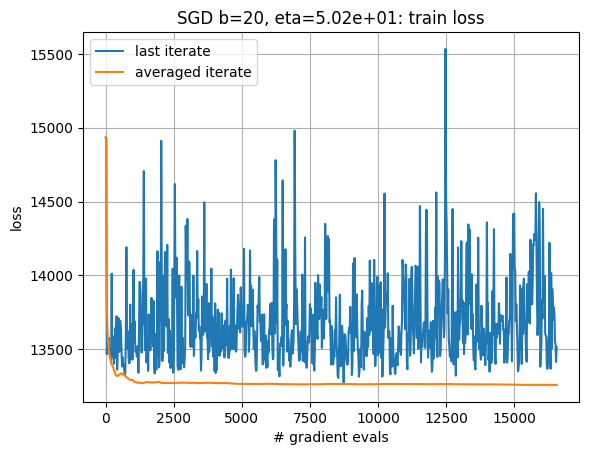

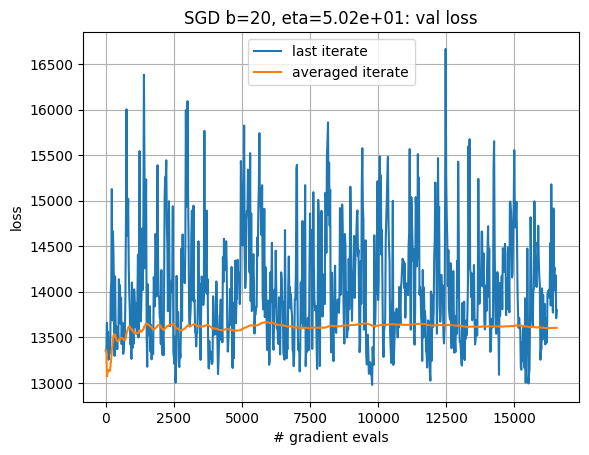

In [12]:
L = smoothness_L(X_train, lam)
eta = 0.5 / L
b = 20
budget = 50 * X_train.shape[0]

evals, tr_last, va_last, wT, _ = run_sgd(
    X_train, y_train, X_val, y_val, lam, eta, b, budget, seed=0, averaging=False
)

evals2, tr_avg, va_avg, wT2, wbar = run_sgd(
    X_train, y_train, X_val, y_val, lam, eta, b, budget, seed=0, averaging=True
)

plot_curves(evals, {"last iterate": tr_last, "averaged iterate": tr_avg},
            f"SGD b={b}, eta={eta:.2e}: train loss", "# gradient evals")

plot_curves(evals, {"last iterate": va_last, "averaged iterate": va_avg},
            f"SGD b={b}, eta={eta:.2e}: val loss", "# gradient evals")


## Part III: Effect of Batch Size

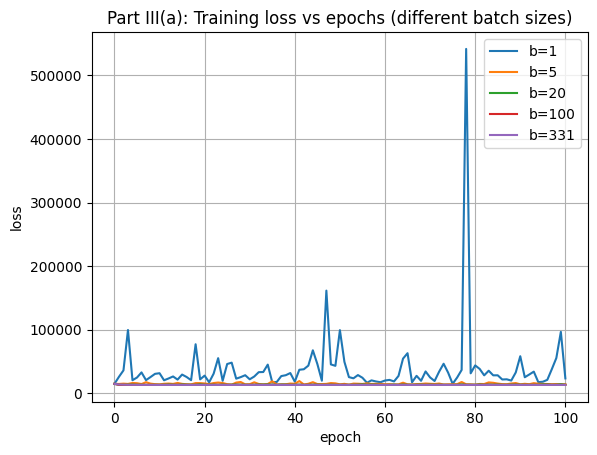

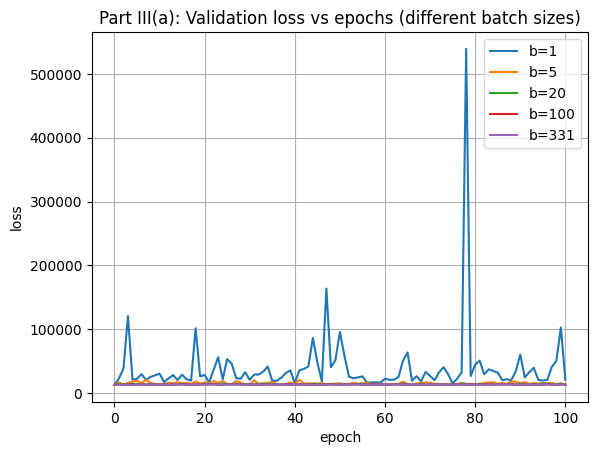

In [13]:
# ========== Part III(a): Optimization vs. Statistical Error ==========
# Plot train/val loss vs epochs for different batch sizes
L = smoothness_L(X_train, lam)
eta_III = 0.5 / L
num_epochs = 100
batch_sizes_IIIa = [1, 5, 20, 100, X_train.shape[0]]
seed = 42

train_by_b = {}
val_by_b = {}
for b in batch_sizes_IIIa:
    ep, tr, va, _ = run_sgd_epochs(X_train, y_train, X_val, y_val, lam, eta_III, b, num_epochs, seed=seed)
    train_by_b[f"b={b}"] = tr
    val_by_b[f"b={b}"] = va

plot_curves(ep, train_by_b, "Part III(a): Training loss vs epochs (different batch sizes)", "epoch")
plot_curves(ep, val_by_b, "Part III(a): Validation loss vs epochs (different batch sizes)", "epoch")

### Part III(a) Discussion: Optimization vs. Statistical Error
- **Small b (e.g. b=1)**: High variance in stochastic gradients; loss curve is noisier. Early on, **optimization error** dominates (we are far from the optimum). As epochs increase, loss decreases but **statistical noise** is visible (fluctuations).
- **Large b (e.g. full batch)**: Low variance; smooth curves. **Optimization error** dominates throughout (fewer, noiseless updates per epoch). Less statistical noise.
- **Regime**: Early epochs / small b → more statistical noise. Late epochs / large b → optimization error (bias of the estimator, convergence speed) dominates.

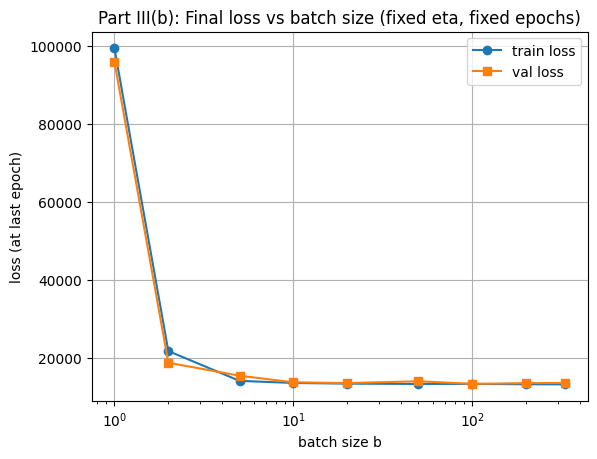

In [14]:
# ========== Part III(b): Critical Batch Size ==========
# Fix step size eta, vary batch size b; measure final loss (or loss at fixed epochs)
eta_IIIb = 0.5 / L
num_epochs_IIIb = 50
batch_sizes_IIIb = [1, 2, 5, 10, 20, 50, 100, 200, X_train.shape[0]]
batch_sizes_IIIb = [b for b in batch_sizes_IIIb if b <= X_train.shape[0]]

final_tr = []
final_va = []
for b in batch_sizes_IIIb:
    ep, tr, va, _ = run_sgd_epochs(X_train, y_train, X_val, y_val, lam, eta_IIIb, b, num_epochs_IIIb, seed=seed)
    final_tr.append(tr[-1])
    final_va.append(va[-1])

plt.figure()
plt.semilogx(batch_sizes_IIIb, final_tr, "o-", label="train loss")
plt.semilogx(batch_sizes_IIIb, final_va, "s-", label="val loss")
plt.xlabel("batch size b")
plt.ylabel("loss (at last epoch)")
plt.title("Part III(b): Final loss vs batch size (fixed eta, fixed epochs)")
plt.legend()
plt.grid(True)
os.makedirs(FIG_DIR, exist_ok=True)
plt.savefig(os.path.join(FIG_DIR, "Part_IIIb_final_loss_vs_batch_size.png"), bbox_inches="tight")
plt.show()

### Part III(b) Discussion: Critical Batch Size and Variance
- **Critical batch size**: Beyond some b (e.g. around 5 here), increasing batch size gives diminishing returns; performance (final loss) saturates.
- **Relation to variance**: Var(minibatch gradient) scales roughly like 1/b (under i.i.d. sampling). So for small b, variance is large and many updates are "wasted" in noise; for large b, variance is small and each update is close to the full gradient. Once b is large enough, variance is already low and further increasing b does not improve convergence much per epoch—hence saturation.